In [1]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
#from transformers import AutoTokenizer
import tiktoken

from src.dataimport import list_files, list_files_with_extension, list_files_with_extension_directory, load_text
from src.llmlib import num_tokens_from_string

In [2]:
# Hilffunktionen
model_id = "gpt-4o-mini-2024-07-18"

# def calculate_token_count(text):
#     tokenizer = AutoTokenizer.from_pretrained(model_id)
#     tokenized_text = tokenizer(text, return_tensors="pt") # pt = PyTorch
#     return tokenized_text.input_ids.size()[1]


# Dateien laden

In [3]:
# Example usage
RAW_FILES_PATH = 'data/original/brat-project-final/'
TRANSFORMED_FILES_PATH = 'data/transformed/'
list_files(TRANSFORMED_FILES_PATH)[:7]

['essay001.ann',
 'essay001.json',
 'essay002.ann',
 'essay002.json',
 'essay003.ann',
 'essay003.json',
 'essay004.ann']

In [4]:
files_directory_txt = list_files_with_extension_directory(RAW_FILES_PATH, '.txt')
files_directory_ann = list_files_with_extension_directory(RAW_FILES_PATH, '.ann')
files_directory_json = list_files_with_extension_directory(TRANSFORMED_FILES_PATH, '.json')
print(files_directory_txt)
print(files_directory_ann)
print(files_directory_json)

['data/original/brat-project-final/essay001.txt', 'data/original/brat-project-final/essay002.txt', 'data/original/brat-project-final/essay003.txt', 'data/original/brat-project-final/essay004.txt', 'data/original/brat-project-final/essay005.txt', 'data/original/brat-project-final/essay006.txt', 'data/original/brat-project-final/essay007.txt', 'data/original/brat-project-final/essay008.txt', 'data/original/brat-project-final/essay009.txt', 'data/original/brat-project-final/essay010.txt', 'data/original/brat-project-final/essay011.txt', 'data/original/brat-project-final/essay012.txt', 'data/original/brat-project-final/essay013.txt', 'data/original/brat-project-final/essay014.txt', 'data/original/brat-project-final/essay015.txt', 'data/original/brat-project-final/essay016.txt', 'data/original/brat-project-final/essay017.txt', 'data/original/brat-project-final/essay018.txt', 'data/original/brat-project-final/essay019.txt', 'data/original/brat-project-final/essay020.txt', 'data/original/brat

In [5]:
print(len(files_directory_txt))
print(len(files_directory_ann))
print(len(files_directory_json))

402
402
402


# Analyse der Essays (TXT-Dateien)

In [6]:
# Beispieltext laden    
text = load_text(files_directory_txt[0])
print(text)

Should students be taught to compete or to cooperate?

It is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that we should attach more importance to cooperation during primary education.
First of all, through cooperation, children can learn about interpersonal skills which are significant in the future life of all students. What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others. During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think compr

In [7]:
def calculate_txt_file_lengths(files_path_list):
    """
    Calculate the number of characters and words in each text file in the given directory.
    """
    file_lengths = []

    for file_path in files_path_list:
        with open(file_path, 'r') as f:
            content = f.read()
            char_count = len(content) # count characters
            word_count = len(content.split()) # count words
            token_count = num_tokens_from_string(content, model_id) # count tokens
            file_lengths.append({'FileName': os.path.basename(file_path),
                                 'txt': content, 
                                 'CharCount': char_count,
                                 'WordCount': word_count,
                                 'TokenCount_txt': token_count})

    df_lengths = pd.DataFrame(file_lengths)
    return df_lengths

In [8]:
txt_lengths_df = calculate_txt_file_lengths(files_directory_txt)
txt_lengths_df

,FileName,txt,CharCount,WordCount,TokenCount_txt
0,essay001.txt,Should students be taught to compete or to coo...,2232,376,419
1,essay002.txt,More people are migrating to other countries t...,2078,333,374
2,essay003.txt,International tourism is now more common than ...,1789,260,303
3,essay004.txt,International tourism is now more common than ...,1884,288,328
4,essay005.txt,Living and studying overseas\n\nIt is every st...,1654,262,293
...,...,...,...,...,...
397,essay398.txt,We can not forcedly put the same numbers of ma...,1952,325,365
398,essay399.txt,"Drugs, alcohol and messy sex lives\n\nCelebrit...",1550,263,300
399,essay400.txt,A greater proportion of the budget should be a...,1813,284,304
400,essay401.txt,Fatherhood should be as present as motherhood ...,1669,280,320


In [9]:
#Duplikate
duplicate_files = txt_lengths_df[txt_lengths_df.duplicated(subset=['txt'], keep=False)][['FileName', 'txt']]
duplicate_files

,FileName,txt
170,essay171.txt,A greater proportion of the budget should be a...
208,essay209.txt,University education restriction\n\nUniverstiy...
209,essay210.txt,A greater proportion of the budget should be a...
376,essay377.txt,University education restriction\n\nUniverstiy...
399,essay400.txt,A greater proportion of the budget should be a...


In [10]:
duplicate_files_list = duplicate_files['FileName'].tolist()
duplicate_files_list

['essay171.txt',
 'essay209.txt',
 'essay210.txt',
 'essay377.txt',
 'essay400.txt']

In [ ]:
# Enfernen von Duplikaten
txt_lengths_df = txt_lengths_df.drop_duplicates(subset=['txt'], keep='first')
# statische Analyse
txt_lengths_df.describe()

,CharCount,WordCount,TokenCount_txt
count,399.000000,399.000000,399.000000
mean,1976.060150,327.558897,372.300752
std,321.514548,56.229885,63.479825
min,1243.000000,199.000000,225.000000
25%,1766.000000,289.500000,326.000000
50%,1941.000000,319.000000,362.000000
75%,2175.500000,359.000000,408.500000
max,2847.000000,504.000000,564.000000


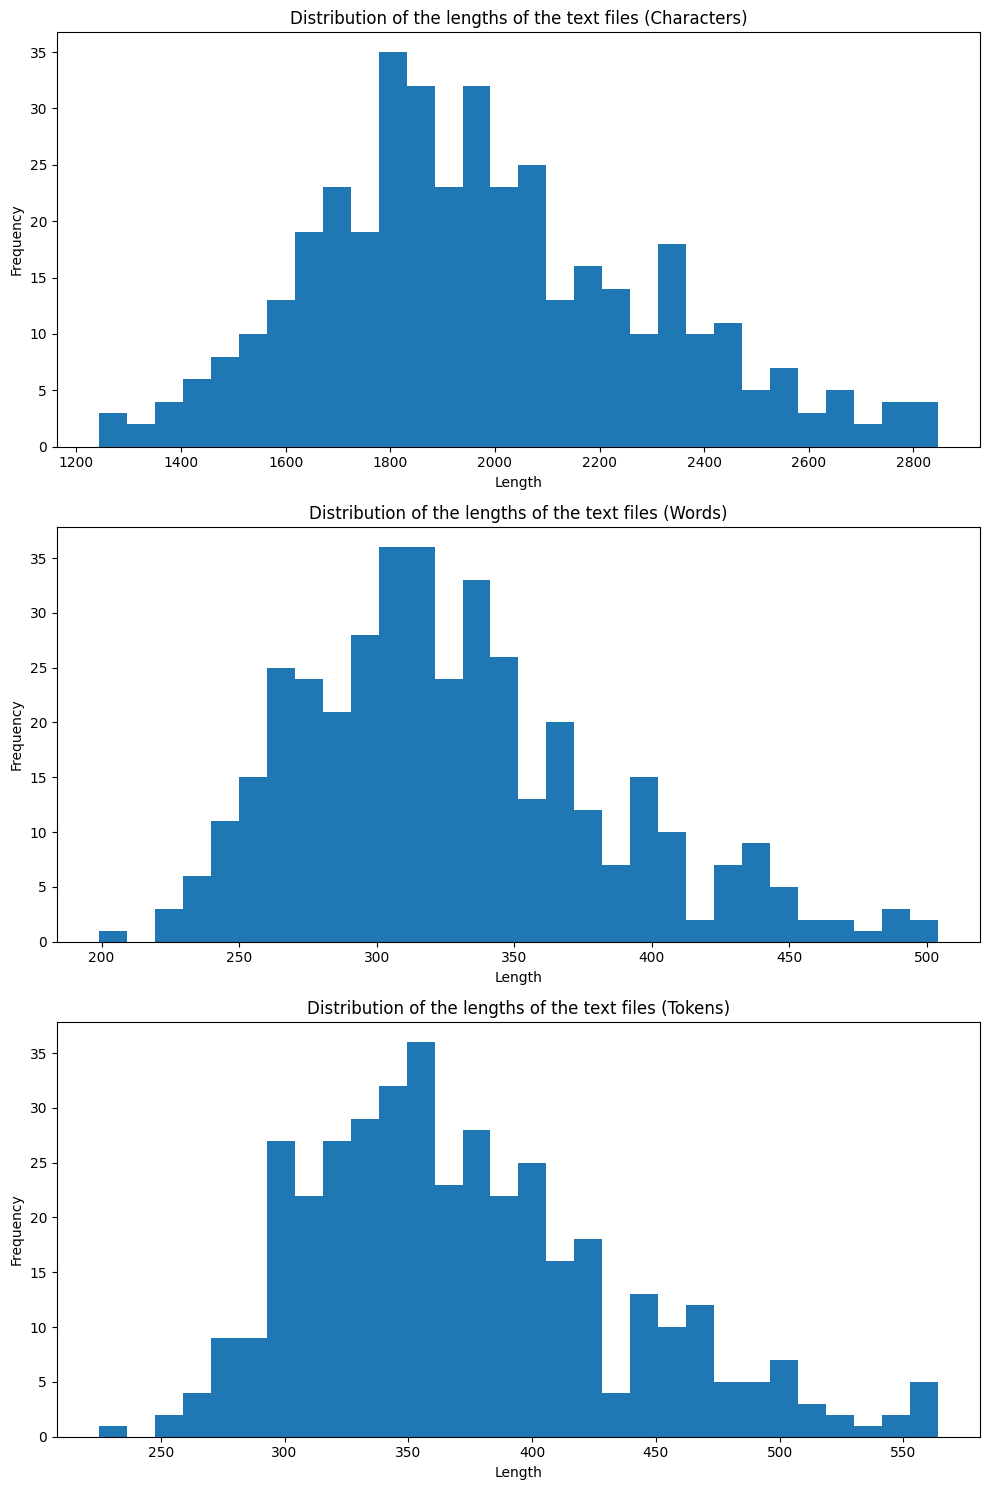

In [12]:
# distribution of the lengths of the text files
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Character count distribution
axs[0].hist(txt_lengths_df['CharCount'], bins=30)
axs[0].set_title('Distribution of the lengths of the text files (Characters)')
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Frequency')

# Word count distribution
axs[1].hist(txt_lengths_df['WordCount'], bins=30)
axs[1].set_title('Distribution of the lengths of the text files (Words)')
axs[1].set_xlabel('Length')
axs[1].set_ylabel('Frequency')

# Token count distribution
axs[2].hist(txt_lengths_df['TokenCount_txt'], bins=30)
axs[2].set_title('Distribution of the lengths of the text files (Tokens)')
axs[2].set_xlabel('Length')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

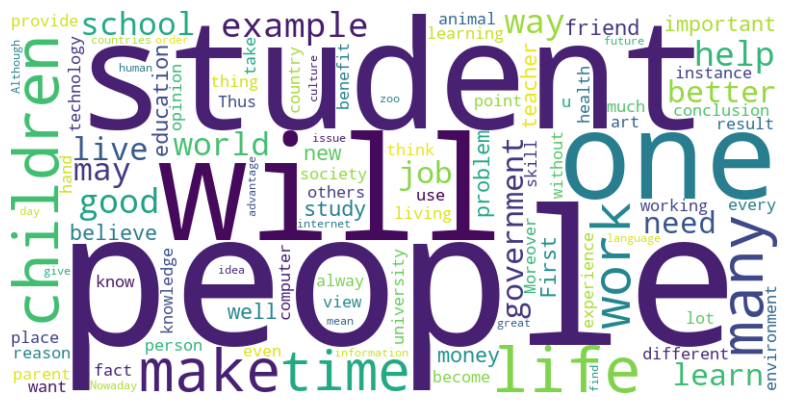

In [13]:
# Combine all text files into a single string
all_text = ''
for file_path in files_directory_txt:
    with open(file_path, 'r') as file:
        all_text += file.read() + ' '
# stopwords
stopwords = set(STOPWORDS)
# stopwords.update(['word1','word2'])

# Generate the word cloud
wordcloud = WordCloud(width=800,
                      height=400,
                      stopwords=stopwords,
                      background_color='white',
                      max_words=100, # default: 200
                      random_state=42
                      ).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear') # bilinear interpolation to make the displayed image appear more smoothly
plt.axis('off')
#plt.title('Word Cloud for Text Files')
plt.show()

# save to file
# wordcloud.to_file('wordcloud.png')

# Quelle für Wordcloud: https://www.datacamp.com/tutorial/wordcloud-python

# Analyse der Annotationen (ANN-Dateien )

In [14]:
#Beispiel für ANN-Datei
print(load_text(files_directory_ann[0]))

T1	MajorClaim 503 575	we should attach more importance to cooperation during primary education
T2	MajorClaim 2154 2231	a more cooperative attitudes towards life is more profitable in one's success
T3	Claim 591 714	through cooperation, children can learn about interpersonal skills which are significant in the future life of all students
A1	Stance T3 For
T4	Premise 716 851	What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others
T5	Premise 853 1086	During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think comprehensively, and even how to compromise with other team members when conflicts occurred
T6	Premise 1088 1191	All of these skills help them to get on well with other people and will benefit them for the whole life
R1	supports Arg1:T4 Arg2:T3	
R2	supports Arg1:T5 Arg2:T3	
R3	supports Arg1:T6 Arg2:T3	
T7	Claim 1332 1376	compe

In [15]:
def load_ann_files(files_path_list):
    """
    Load .ann files and store them in a DataFrame with filename and content.
    """
    data = []

    for file_path in files_path_list:
        file_name = os.path.basename(file_path)
        with open(file_path, 'r') as file:
            content = file.read()
        data.append({'FileName': file_name, 'Content': content})

    df = pd.DataFrame(data)
    return df

ann_files_df = load_ann_files(files_directory_ann)
ann_files_df

,FileName,Content
0,essay001.ann,T1\tMajorClaim 503 575\twe should attach more ...
1,essay002.ann,T1\tMajorClaim 391 489\tthey are able to susta...
2,essay003.ann,T1\tMajorClaim 352 475\tit has contributed to ...
3,essay004.ann,T1\tMajorClaim 262 376\tthis industry has affe...
4,essay005.ann,T1\tMajorClaim 286 359\tone who studies overse...
...,...,...
397,essay398.ann,T1\tClaim 254 318\tmany different characters e...
398,essay399.ann,T1\tMajorClaim 367 429\tthis is a worrying tre...
399,essay400.ann,T1\tMajorClaim 274 387\tgovernments should dev...
400,essay401.ann,T1\tMajorClaim 311 384\tfatherhood is a as vit...


In [16]:
# Überprüfung auf Duplikate - wenn der DF leer ist, gibt es keine Duplikate
duplicate_ann_files = ann_files_df[ann_files_df.duplicated(subset=['Content'], keep=False)]
duplicate_ann_files

,FileName,Content


## Anzahl MajorClaims, Claims, Premissen und Beziehungen zählen

In [30]:
def count_entities(files_list):
    data = []
    for file_path in files_list:
        file_name = os.path.basename(file_path)
        majorclaims = 0
        claims = 0
        premises = 0
        #stances = 0
        relation = 0 # stances werden als Beziehungen gezählt
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    entity = line.split('\t')[1].split(' ')[0]
                    if entity == 'MajorClaim':
                        majorclaims += 1
                    elif entity == 'Claim':
                        claims += 1
                    elif entity == 'Premise':
                        premises += 1
                elif line.startswith('A'):
                    entity = line.split('\t')[1].split(' ')[0]
                    if entity == 'Stance':
                        relation += 1
                elif line.startswith('R'):
                    relation += 1
            token_count = num_tokens_from_string(' '.join(lines), model_id)

        data.append({'FileName': file_name,
                     'MajorClaims': majorclaims,
                     'Claims': claims,
                     'Premises': premises,
                     #'Stances': stances,
                     'Relations': relation,
                     'Total': majorclaims + claims + premises + relation,
                     'TokenCount_ann': token_count})
    
    df = pd.DataFrame(data)
    
    return df

In [31]:
count_df = count_entities(files_directory_ann)

# sort the files by the number of entities
count_df = count_df.sort_values(by=['Total'], ascending=False)
count_df

,FileName,MajorClaims,Claims,Premises,Relations,Total,TokenCount_ann
168,essay169.ann,2,6,20,26,54,1044
160,essay161.ann,2,8,16,24,50,980
153,essay154.ann,2,6,18,24,50,987
285,essay286.ann,2,5,18,23,48,913
311,essay312.ann,2,4,19,23,48,886
...,...,...,...,...,...,...,...
102,essay103.ann,1,3,4,7,15,358
32,essay033.ann,1,3,4,7,15,328
139,essay140.ann,2,2,4,6,14,384
170,essay171.ann,2,2,4,6,14,354


In [32]:
count_df.describe()

,MajorClaims,Claims,Premises,Relations,Total,TokenCount_ann
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,1.868159,3.746269,9.532338,13.278607,28.425373,593.925373
std,0.452239,1.158423,3.405321,3.847724,7.780701,140.771067
min,1.000000,2.000000,2.000000,5.000000,12.000000,291.000000
25%,2.000000,3.000000,7.000000,10.000000,22.000000,491.000000
50%,2.000000,4.000000,9.000000,13.000000,28.000000,578.500000
75%,2.000000,4.000000,12.000000,16.000000,34.000000,691.000000
max,3.000000,10.000000,20.000000,26.000000,54.000000,1044.000000


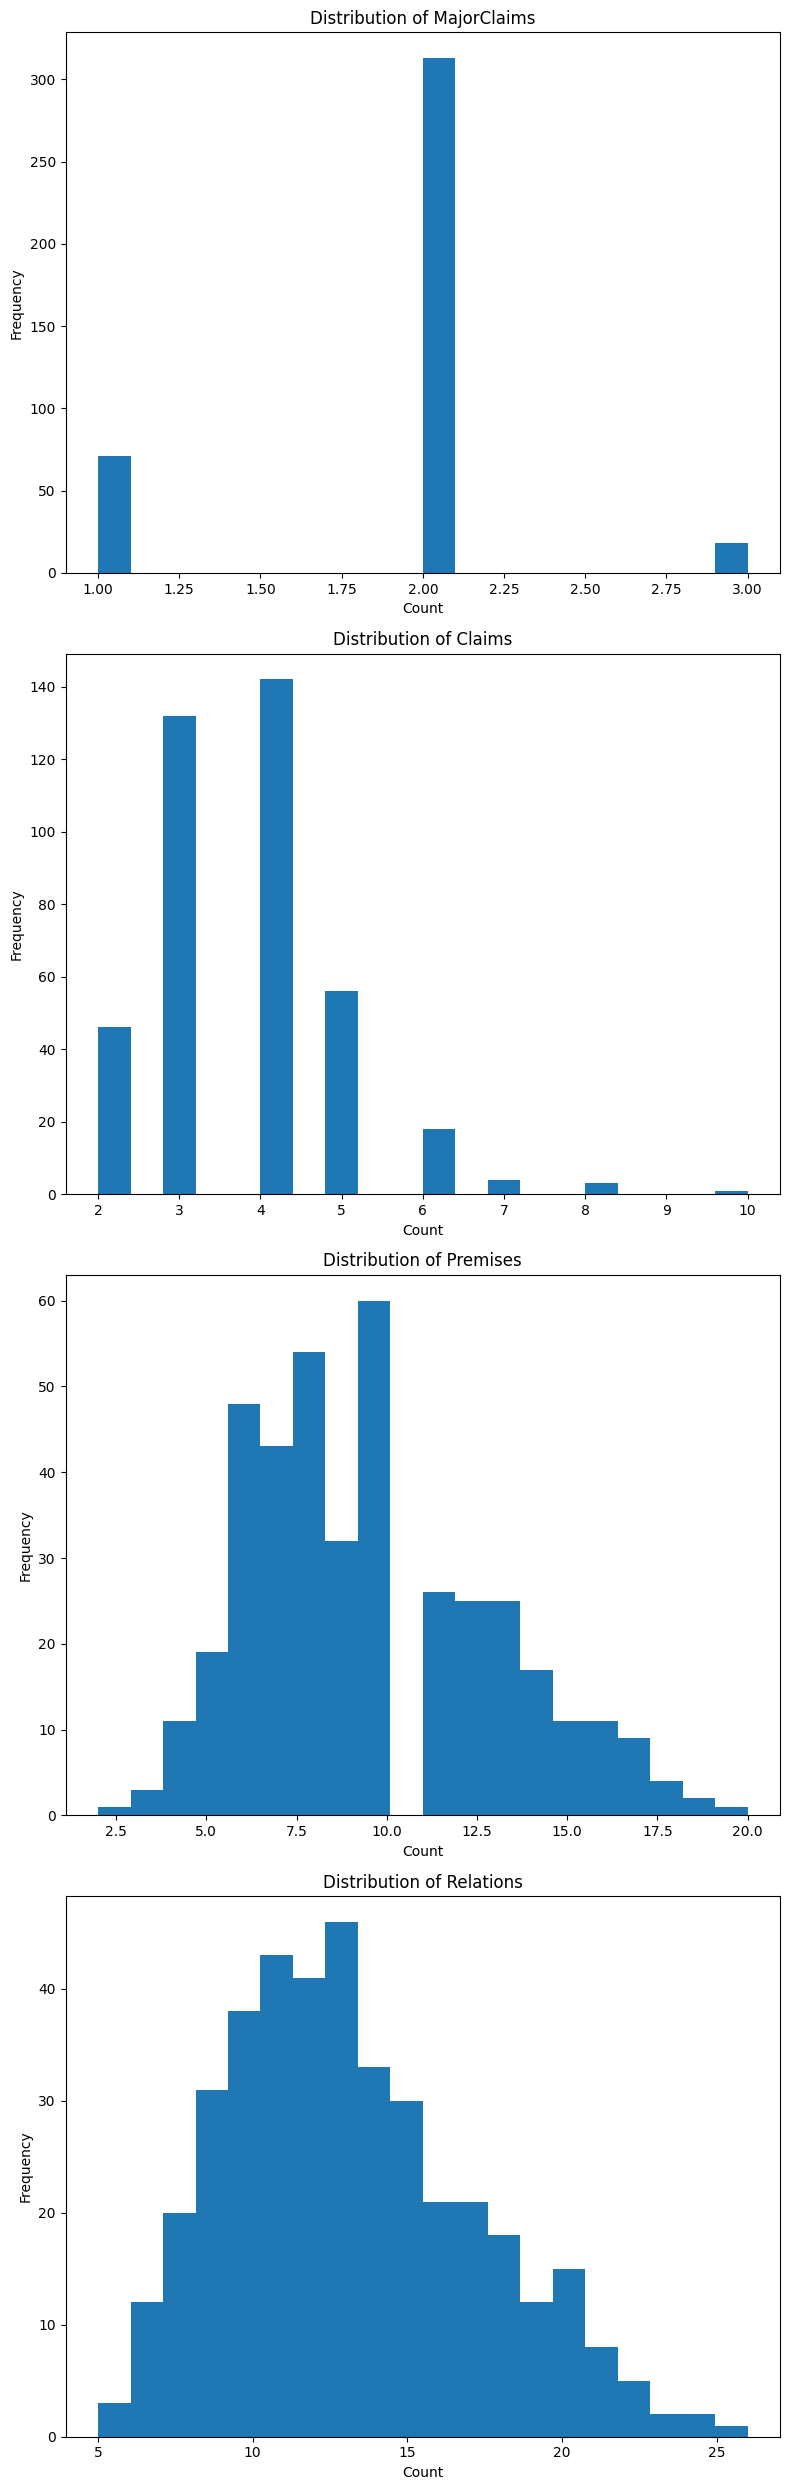

In [38]:
# distribution of the number of entities in the text files
fig, axs = plt.subplots(4, 1, figsize=(8, 25))

# MajorClaims count distribution
axs[0].hist(count_df['MajorClaims'], bins=20)
axs[0].set_title('Distribution of MajorClaims')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Frequency')

# Claims count distribution
axs[1].hist(count_df['Claims'], bins=20)
axs[1].set_title('Distribution of Claims')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Frequency')

# Premises count distribution
axs[2].hist(count_df['Premises'], bins=20)
axs[2].set_title('Distribution of Premises')
axs[2].set_xlabel('Count')
axs[2].set_ylabel('Frequency')

# Relations count distribution
axs[3].hist(count_df['Relations'], bins=20)
axs[3].set_title('Distribution of Relations')
axs[3].set_xlabel('Count')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# # distribution of the total number of entities in the text files
# plt.hist(count_df['Total'], bins=20)
# plt.title('Distribution of the total number of entities in the text files')
# plt.xlabel('Count')
# plt.ylabel('Frequency')
# plt.show()

# # distribution of the token count in the text files
# plt.hist(count_df['TokenCount'], bins=30)
# plt.title('Distribution of the token count in the text files')
# plt.xlabel('Count')
# plt.ylabel('Frequency')
# plt.show()

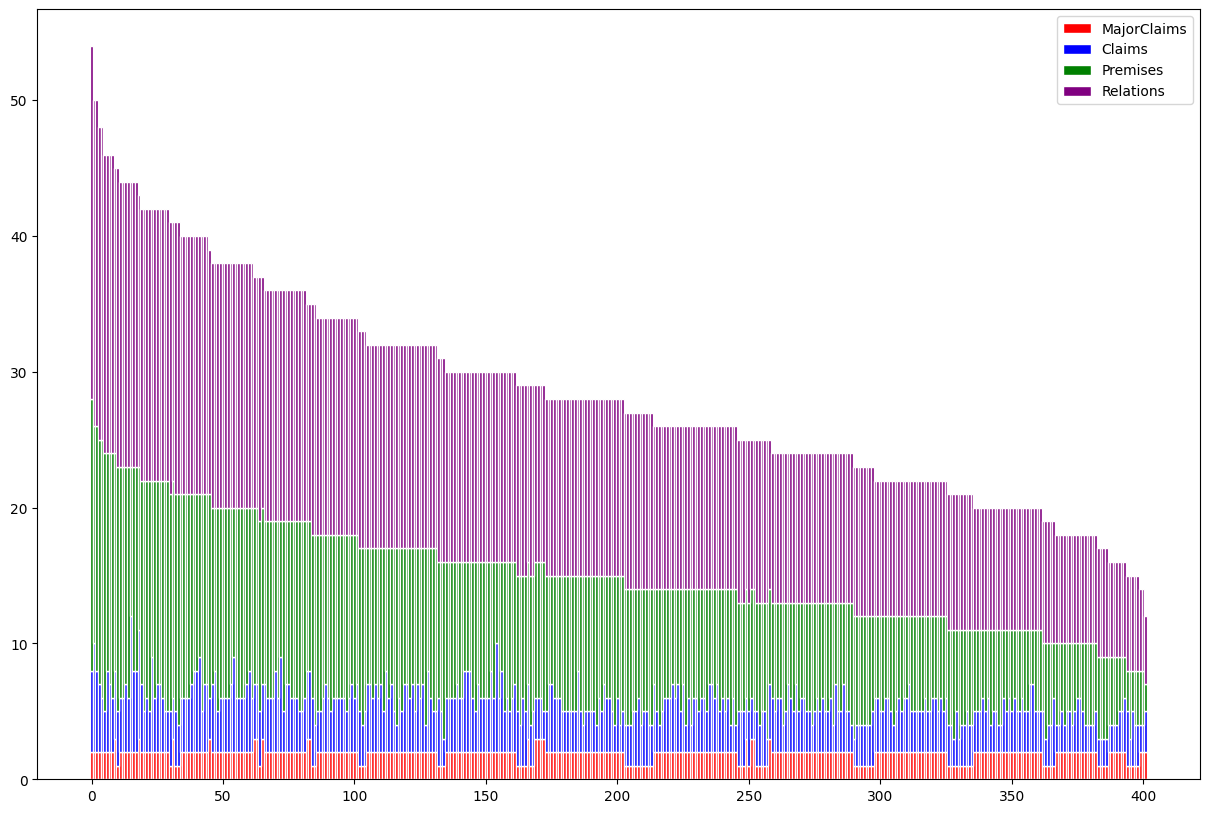

In [40]:
# plot stacked bar chart for the number of entities in each file
fig, ax = plt.subplots(figsize=(15, 10))

barWidth = 1
r = range(len(count_df))

plt.bar(r, count_df['MajorClaims'], color='red', edgecolor='white', width=barWidth, label='MajorClaims')
plt.bar(r, count_df['Claims'], bottom=count_df['MajorClaims'], color='blue', edgecolor='white', width=barWidth, label='Claims')
plt.bar(r, count_df['Premises'], bottom=count_df['MajorClaims'] + count_df['Claims'], color='green', edgecolor='white', width=barWidth, label='Premises')
plt.bar(r, count_df['Relations'], bottom=count_df['MajorClaims'] + count_df['Claims'] + count_df['Premises'], color='purple', edgecolor='white', width=barWidth, label='Relations')
plt.legend()


# Essays with annotations (TXT- und ANN-Dateien)

In [55]:
# combine the text and annotation dataframes using the file name without the extension
txt_lengths_df.loc[:, 'FileName'] = txt_lengths_df['FileName'].str.replace('.txt', '')
count_df.loc[:, 'FileName'] = count_df['FileName'].str.replace('.ann', '')

combined_df = pd.merge(left=txt_lengths_df, right=count_df, on='FileName')
combined_df['TokenCount_sum'] = combined_df['TokenCount_txt'] + combined_df['TokenCount_ann']
combined_df

,FileName,txt,CharCount,WordCount,TokenCount_txt,MajorClaims,Claims,Premises,Relations,Total,TokenCount_ann,TokenCount_sum
0,essay001,Should students be taught to compete or to coo...,2232,376,419,2,3,6,9,20,486,905
1,essay002,More people are migrating to other countries t...,2078,333,374,2,3,9,12,26,582,956
2,essay003,International tourism is now more common than ...,1789,260,303,2,2,6,8,18,421,724
3,essay004,International tourism is now more common than ...,1884,288,328,2,3,6,9,20,461,789
4,essay005,Living and studying overseas\n\nIt is every st...,1654,262,293,2,4,6,10,22,474,767
...,...,...,...,...,...,...,...,...,...,...,...,...
394,essay397,Modern technology has impacted the traditional...,1765,271,312,2,3,6,9,20,475,787
395,essay398,We can not forcedly put the same numbers of ma...,1952,325,365,1,4,11,15,31,647,1012
396,essay399,"Drugs, alcohol and messy sex lives\n\nCelebrit...",1550,263,300,2,3,5,8,18,379,679
397,essay401,Fatherhood should be as present as motherhood ...,1669,280,320,2,2,6,8,18,439,759


In [56]:
combined_df[['TokenCount_txt', 'TokenCount_ann', 'TokenCount_sum']].describe()

,TokenCount_txt,TokenCount_ann,TokenCount_sum
count,399.000000,399.000000,399.000000
mean,372.300752,595.145363,967.446115
std,63.479825,140.588529,193.250408
min,225.000000,291.000000,554.000000
25%,326.000000,491.000000,822.500000
50%,362.000000,579.000000,947.000000
75%,408.500000,692.500000,1091.000000
max,564.000000,1044.000000,1506.000000


In [57]:
# 10 files with the smallest token count
smalest_10_token_sum = combined_df.nsmallest(10, 'TokenCount_sum')
smalest_10_token_sum

,FileName,txt,CharCount,WordCount,TokenCount_txt,MajorClaims,Claims,Premises,Relations,Total,TokenCount_ann,TokenCount_sum
87,essay088,"The expression ""Never, never give up"" means ke...",1329,233,263,2,3,2,5,12,291,554
393,essay396,Arts and public services are both important to...,1275,199,225,2,2,5,7,16,343,568
333,essay335,There have been significant developments in th...,1429,227,267,1,4,3,7,15,305,572
32,essay033,Effects of globalization\n\nDuring the history...,1554,244,266,1,3,4,7,15,328,594
380,essay383,Negative effects of technological process\n\nI...,1761,253,288,1,4,3,7,15,322,610
120,essay121,Businesses should be only concerned about maki...,1309,223,249,2,4,3,7,16,365,614
236,essay238,Reasons why travelers visit Museums?\n\nMany p...,1289,223,249,2,4,4,8,18,380,629
370,essay372,The maintenance of traditional skills and ways...,1514,241,275,2,3,4,7,16,364,639
122,essay123,Parents or other adult relatives should make i...,1381,239,268,2,2,7,9,20,379,647
366,essay368,Smoking should be made prohibited in public pl...,1688,261,302,2,2,5,7,16,345,647


In [58]:
print(f"Die 10 Dateien mit der geringsten Tokenanzahl haben insgesamt {smalest_10_token_sum['TokenCount_sum'].sum()} Tokens.")
print(f"Davon entfallen {smalest_10_token_sum['TokenCount_txt'].sum()} Tokens auf die Textdateien und {smalest_10_token_sum['TokenCount_ann'].sum()} Tokens auf die Annotationsdateien.")

Die 10 Dateien mit der geringsten Tokenanzahl haben insgesamt 6074 Tokens.
Davon entfallen 2652 Tokens auf die Textdateien und 3422 Tokens auf die Annotationsdateien.


Das Tokenfenster von Llama 3.2 über die Huggingface API ist auf 4096 Token begrenzt. Daher muss die Summer der Input-Token und Output-Token kleiner als die Grenze sein. Bspw. indem man die Anzahl der Beispiele reduziert oder sich nur auf die Annotationen konzentriert.

Nachfolgend werden die Tokenanzahlen der Texte und Annotationen einzeln betrachtet.

In [59]:
smalest_10_token_txt = combined_df.nsmallest(10, 'TokenCount_txt')
smalest_10_token_txt

,FileName,txt,CharCount,WordCount,TokenCount_txt,MajorClaims,Claims,Premises,Relations,Total,TokenCount_ann,TokenCount_sum
393,essay396,Arts and public services are both important to...,1275,199,225,2,2,5,7,16,343,568
120,essay121,Businesses should be only concerned about maki...,1309,223,249,2,4,3,7,16,365,614
236,essay238,Reasons why travelers visit Museums?\n\nMany p...,1289,223,249,2,4,4,8,18,380,629
87,essay088,"The expression ""Never, never give up"" means ke...",1329,233,263,2,3,2,5,12,291,554
32,essay033,Effects of globalization\n\nDuring the history...,1554,244,266,1,3,4,7,15,328,594
333,essay335,There have been significant developments in th...,1429,227,267,1,4,3,7,15,305,572
122,essay123,Parents or other adult relatives should make i...,1381,239,268,2,2,7,9,20,379,647
74,essay075,Do arts and music improve the quality of life?...,1446,244,271,2,4,5,9,20,456,727
88,essay089,Some people think that human needs for farmlan...,1453,239,272,2,6,8,14,30,528,800
385,essay388,Gun control and increasing violence\n\nSome pe...,1414,238,273,2,4,6,10,22,410,683


In [60]:
print(f"Die 10 Dateien mit der geringsten Tokenanzahl in den Textdateien haben insgesamt {smalest_10_token_txt['TokenCount_txt'].sum()} Tokens.")

Die 10 Dateien mit der geringsten Tokenanzahl in den Textdateien haben insgesamt 2603 Tokens.


In [61]:
smalest_10_tokenann = combined_df.nsmallest(10, 'TokenCount_ann')
smalest_10_tokenann

,FileName,txt,CharCount,WordCount,TokenCount_txt,MajorClaims,Claims,Premises,Relations,Total,TokenCount_ann,TokenCount_sum
87,essay088,"The expression ""Never, never give up"" means ke...",1329,233,263,2,3,2,5,12,291,554
333,essay335,There have been significant developments in th...,1429,227,267,1,4,3,7,15,305,572
380,essay383,Negative effects of technological process\n\nI...,1761,253,288,1,4,3,7,15,322,610
32,essay033,Effects of globalization\n\nDuring the history...,1554,244,266,1,3,4,7,15,328,594
45,essay046,True function of a university\n\nUniversities ...,1925,310,348,1,2,5,7,15,340,688
393,essay396,Arts and public services are both important to...,1275,199,225,2,2,5,7,16,343,568
366,essay368,Smoking should be made prohibited in public pl...,1688,261,302,2,2,5,7,16,345,647
70,essay071,Should all the advertisements be banned?\n\nNe...,1677,266,304,2,3,4,7,16,348,652
170,essay171,A greater proportion of the budget should be a...,1813,284,304,2,2,4,6,14,354,658
102,essay103,Jury must have access to criminals' past recor...,1604,262,295,1,3,4,7,15,358,653


In [62]:
print(f"Die 10 Dateien mit der geringsten Tokenanzahl in den Annotationsdateien haben insgesamt {smalest_10_tokenann['TokenCount_ann'].sum()} Tokens.")

Die 10 Dateien mit der geringsten Tokenanzahl in den Annotationsdateien haben insgesamt 3334 Tokens.
